# Q learning for Tic Tac Toe


In [0]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [0]:
class Game:
  """
    A class used to represent a tic-tac-toe game

    ...

    Methods
    -------
    isFree(pos)
        returns True if position pos in the board is free
      
    availableMoves(self)
        returns a list of the available positions in the board

    canPlay(player)
        returns True if player can make a move

    isOver()
        returns True if the game is over

    move(player,pos,verbose=True)
        makes player move to position pos
    
    verify()
        check the status of the game (still on, winners, drawn)
    
    getState()
        return a vector representing the state of the game
    
    print()
        print the board of the game
    """

  def __init__(self):
    self.matrix=np.zeros([3,3]) #game board
    self.lastplayer=0           # last player who moved
    self.moves=0                # number of performed moves in the game
    self.won=False              # flag (anyone won?)

  def freeSpace(self,pos):
    row=int(np.floor(pos/3))
    col=int(np.mod(pos,3))
    if self.matrix[row,col]==0:
      return True
    else:
      return False
  
  def availableMoves(self):
    mat2vec=self.matrix.flatten()
    return np.where(mat2vec==0)[0]

  def canPlay(self, player):
    if (self.lastplayer!=player or self.lastplayer==0) and not self.isOver():
      # if not the last player and the game is not over
      return True
    else:
      return False

  def isOver(self):
    # check the status of the game
    self.verify()
    if self.moves==9 or self.won:
      # if the max number of moves has been performed or there is a winner
      return True
    else:
      return False

  def move(self,player,pos,verbose=False):
    if self.canPlay(player):
      # if it is the player turn
      if self.freeSpace(pos):
        # if the position is available
        row=int(np.floor(pos/3))
        col=int(np.mod(pos,3))
        if player==1:
          self.matrix[row,col]=-1
        else:
          self.matrix[row,col]=1
        self.lastplayer=player
        self.moves+=1
        return True
      else:
        if verbose: print('Cannot play on this cell.')
        return False
    else:
      if verbose: print('This player cannot play now.')
      return False
  
  def verify(self):
    rows=np.sum(self.matrix,axis=0)
    cols=np.sum(self.matrix,axis=1)
    diag1=self.matrix[0,0]+self.matrix[1,1]+self.matrix[2,2]
    diag2=self.matrix[2,0]+self.matrix[1,1]+self.matrix[0,2]
    status=-1
    if any(rows==-3) or any(cols==-3) or diag1==-3 or diag2==-3:
      # check if player 1 won
      self.won=True
      status=1
    elif any(rows==3) or any(cols==3) or diag1==3 or diag2==3:
      # check if player 2 won
      self.won=True
      status=2
    elif self.moves==9:
      # check if the game is drawn
      status=0
    return status

  def getState(self):
    return (self.matrix.flatten()+1).astype('int')

  def print(self):
    mat2=self.matrix.copy()
    mat2 = self.matrix.astype(str)  #change data type of array to string
    mat2[mat2=='-1.0']='X'
    mat2[mat2=='0.0']=' '
    mat2[mat2=='1.0']='O'
    print('-------------\n| %s | %s | %s |\n-------------\n| %s | %s | %s |\n-------------\n| %s | %s | %s |\n-------------' % (mat2[0,0],mat2[0, 1],mat2[0,2],mat2[1,0],mat2[1, 1],mat2[1,2],mat2[2,0],mat2[2, 1],mat2[2,2]))

    


The following code simulate 10.000 games in which the players randomly choose the cell where to play. Finally, the probability of drawn, player 1 winning, and player 2 winning are computed.

In [3]:
# Simulate 10.000 games and find the probability of drawn, player 1 win and player 2 win when playing randomly
resvec=np.zeros([1,3])
for game in range(0,10000):
  g=Game()
  vector=np.r_[0:9]
  np.random.shuffle(vector)
  i=0
  player=1
  while not g.isOver():
    g.move(player,vector[i])
    i+=1
    res=g.verify()
    if player==1:
      player=2
    else:
      player=1
  resvec[0,res]+=1
print(resvec/10000)  

[[0.1344 0.5763 0.2893]]


# Player vs Random class
The following class extends the Game class by allowing a player to play vs a random player (i.e., computer)

In [0]:
# player vs random
class IntGame:
  def __init__(self,player,strategy='R'):
    self.g=Game()
    self.player=player     # Human player
    self.strategy=strategy #Adopted strategy, R-random player, B-boring player
    if player==1:
      self.machine=2
    else:
      self.machine=1

    if self.machine==1:
      #player 1 start
      pos=np.random.randint(9)
      self.g.move(1,pos)

  def move(self,pos,verbose=False):
    res=self.g.move(self.player,pos)
    if verbose:
      self.g.print()
    return res

  def opponentMove(self,verbose=False):
      resmachine=False
      while resmachine==False and not self.g.isOver() and self.g.canPlay(self.machine):
        listmoves=self.g.availableMoves()
        if self.strategy=='R':
          pos=listmoves[np.random.randint(np.size(listmoves))]
        else:
          pos=listmoves[0]
        resmachine=self.g.move(self.machine,pos,'True')
      if verbose:
        self.g.print()

  def verify(self):
    res=self.g.verify()
    return res

  def getState(self):
    return self.g.getState()

  def isOver(self):
    return self.g.isOver()
  
  def availableMoves(self):
    return self.g.availableMoves()

  def getMoves(self):
    return self.g.getMoves()


## Q learning agent
The following class define the Q learning agent

In [0]:
class Qagent:
  def __init__(self,alpha,gamma,eps):
    self.alpha=alpha
    self.gamma=gamma
    self.eps=eps
    self.Qtable=np.zeros([3,3,3,3,3,3,3,3,3,9])

  def updateQtable(self,state,action,reward,newstate):
    oldQvalue = self.Qtable[state[0],state[1],state[2],state[3],state[4],state[5],state[6],state[7],state[8],action]
    maxNext = np.max(self.Qtable[newstate[0],newstate[1],newstate[2],newstate[3],newstate[4],newstate[5],newstate[6],newstate[7],newstate[8],:])
    self.Qtable[state[0],state[1],state[2],state[3],state[4],state[5],state[6],state[7],state[8],action]+= self.alpha * (reward+self.gamma*maxNext - oldQvalue)

  def getAction(self, state):
    return np.argmax(self.Qtable[state[0],state[1],state[2],state[3],state[4],state[5],state[6],state[7],state[8],:])

The following simulation allows training the Q learning agent by playing vs a random player.

In [0]:
numsim=30000
#stateaction=np.zeros([3,3,3,3,3,3,3,3,3,9])
alpha=0.2
gamma=0.9
epsilon=0.1
winvec=np.zeros([numsim,1])
player=2

agent = Qagent(alpha,gamma,epsilon)

for i in range(0,numsim):
  #create new game

  gi=IntGame(player,'R')
  while not gi.isOver():
    # check the state of the game
    state=gi.getState()

    #make an action considering e-greedy policy
    res=False
    while res==False:
      if np.random.random(1)<=epsilon:
        #random action
        moves=gi.availableMoves()
        action = moves[np.random.randint(np.size(moves))]
      else:
        action = agent.getAction(state)
      res=gi.move(action)
      
    gi.opponentMove()

    
    #check new state of the environment
    newstate=gi.getState()

    res=gi.verify()
    r = 1* (res==player) + 0


    #update the Q-table
    agent.updateQtable(state,action,r,newstate)
    
  winvec[i] = gi.verify()==player  

Finally, we can plot the probability of victory for the Q learning agent.

Text(0, 0.5, 'Probability of winning')

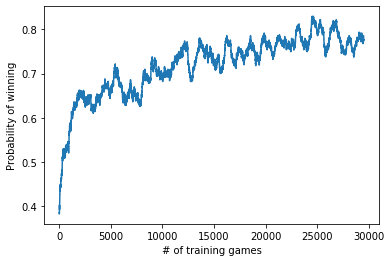

In [13]:
vec=np.zeros([numsim-500,1])
for i in range(500,numsim):
  vec[i-500]=np.sum(winvec[i-500:i])/500
plt.plot(vec)
plt.xlabel('# of training games')
plt.ylabel('Probability of winning')

# Extra

In [0]:
# Human vs random
class IntGameRL:
  def __init__(self,player,Qagent):
    self.g=Game()
    self.player=player
    if player==1:
      self.machine=2
    else:
      self.machine=1

    if self.machine==1:
      #player 1 start
      self.g.move(1,Qagent.getAction(self.g.getState()))

  def move(self,pos,verbose=False):
    res=self.g.move(self.player,pos)
    if verbose:
      self.g.print()
    return res

  def opponentMove(self,verbose=False):
      resmachine=False
      while resmachine==False:
        state=gi.getState()
        if np.random.random(1)<=epsilon:
          #random action
          moves=gi.availableMoves()
          action = moves[np.random.randint(np.size(moves))]
        else:
          action = agent.getAction(state)
        resmachine=self.g.move(self.machine,action)

      if verbose:
        self.g.print()

  def verify(self):
    res=self.g.verify()
    return res

  def getState(self):
    return self.g.getState()

  def isOver(self):
    return self.g.isOver()
  
  def availableMoves(self):
    return self.g.availableMoves()

  def print(self):
    return self.g.print()

In [21]:
player=2
gi=IntGameRL(player,agent)
gi.print()
while not gi.isOver():
  position = int(input('Play (1-9) '))
  gi.move(position-1,True)
  if not gi.isOver():
    gi.opponentMove(True)
res=gi.verify()
if res==-1:
  print('Drawn')
elif res==player:
  print("You Win!")
else:
  print('Computer Win')


-------------
| X |   |   |
-------------
|   |   |   |
-------------
|   |   |   |
-------------
Play (1-9) 5
-------------
| X |   |   |
-------------
|   | O |   |
-------------
|   |   |   |
-------------
-------------
| X | X |   |
-------------
|   | O |   |
-------------
|   |   |   |
-------------
Play (1-9) 3
-------------
| X | X | O |
-------------
|   | O |   |
-------------
|   |   |   |
-------------
-------------
| X | X | O |
-------------
|   | O |   |
-------------
|   | X |   |
-------------
Play (1-9) 7
-------------
| X | X | O |
-------------
|   | O |   |
-------------
| O | X |   |
-------------
You Win!
